# Teacher Forcing in RNNs

**Roberto Fierimonte** - 19/02/2018

---

In [2]:
import scipy
import datetime
import functools
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline 

tfd = tf.contrib.distributions
tfb = tf.contrib.bayesflow

Instructions for updating:
Use the retry module or similar alternatives.


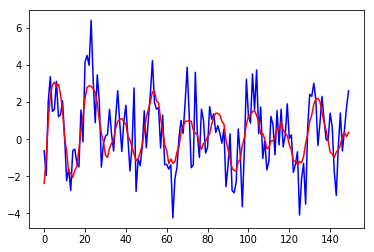

In [2]:
np.random.seed(12)
n_hidden = 10; seq_length = 300;
h = np.zeros((seq_length + 1, n_hidden)); h[0] = np.random.randn(1, n_hidden)
y = np.zeros((seq_length + 1, 1)); y[0] = np.random.randn(1)
sigma_c = 1.2
sigma_b = 0.5

A = 0.05 * np.random.randn(n_hidden, n_hidden)
R = scipy.linalg.expm(A - A.T)
B = 0.01 * np.random.randn(1, n_hidden)
b = np.random.rand(n_hidden, 1)
bias_h = 0

for i in range(1, seq_length + 1):
    h[i] = np.tanh(np.dot(h[i-1], R) + np.dot(y[i-1], B))
    y[i] = 4 * np.tanh(np.dot(h[i], b)) + sigma_b * np.random.rand()

y_tilde = (y[1:] + sigma_c * np.random.randn(seq_length, 20)).T
plt.plot(y_tilde[0, :150], 'b')
plt.plot(y[1:151], 'r')

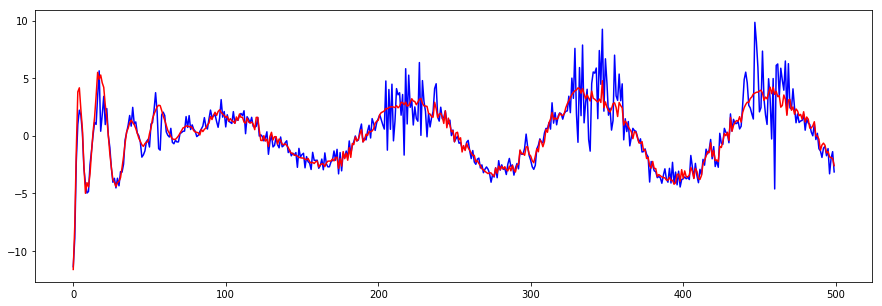

In [362]:
# np.random.seed(7)
# np.random.seed(2)
np.random.seed(1)
n_hidden = 50; seq_length = 500;
h = np.zeros((seq_length + 1, n_hidden)); h[0] = np.random.randn(1, n_hidden)
y = np.zeros((seq_length + 1, 1)); y[0] = np.random.randn(1)
sigma_c = 1.2
# sigma_b = .2

A = 0.8 * np.random.randn(n_hidden, n_hidden)
R = scipy.linalg.expm(A - A.T)
B = 0.02 * np.random.randn(1, n_hidden)
b = np.random.randn(n_hidden, 1)
c = 0.5 * np.random.randn(n_hidden, 1)
bias_h = 0

for i in range(1, seq_length + 1):
    h[i] = 0.3 * np.tanh(np.dot(h[i-1], R) + np.dot(y[i-1], B)) + 0.7 * h[i-1]
    y[i] = 10 * np.tanh(np.dot(h[i], b)) + np.dot(h[i], c) * np.random.randn()

y_tilde = (y[1:] + (1.2 * np.maximum(0, 2 * np.tanh(2 * y[1:] - 4)) + 0.5) * np.random.randn(seq_length, 20)).T
fig, ax = plt.subplots(1,1,figsize=(15, 5))
plt.plot(y_tilde[0], 'b')
plt.plot(y[1:], 'r')
ts = y_tilde[-1]

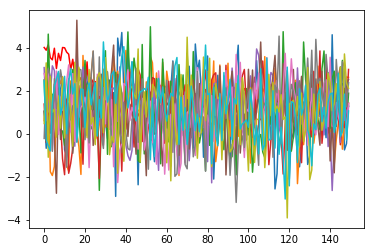

In [342]:
np.random.seed(3)
n_hidden = 50; seq_length = 300;
h = np.zeros((seq_length + 1, n_hidden)); h[0] = np.random.rand(1, n_hidden)
y = np.zeros((seq_length + 1, 1)); y[0] = [0]
sigma_c = 1.2

A = 0.02 * np.random.randn(n_hidden, n_hidden)
R = scipy.linalg.expm(A - A.T)
B = 0.001 * np.random.rand(1, n_hidden)
b = np.random.rand(n_hidden, 1)
bias_h = 0

for i in range(1, seq_length + 1):
    h[i] = np.tanh(np.dot(h[i-1], R) + np.dot(y[i-1], B) + bias_h)
    y[i] = 4 * np.tanh(np.dot(h[i], b)) + 2 * np.random.rand()

y_tilde = (y[1:] + sigma_c * np.random.randn(seq_length, 20)).T
plt.plot(y[1:151], 'r')

idxs = []
X = np.zeros((10, 150))
for i in range(10):
    idx = np.random.randint(0, 150)
    idxs.append(idx)
    X[i] = y_tilde[i, idx:idx+150]
    plt.plot(X[i])

In [5]:
def doublewrap(function):
    """
    A decorator decorator, allowing to use the decorator to be used without
    parentheses if not arguments are provided. All arguments must be optional.
    """
    @functools.wraps(function)
    def decorator(*args, **kwargs):
        if len(args) == 1 and len(kwargs) == 0 and callable(args[0]):
            return function(args[0])
        else:
            return lambda wrapee: function(wrapee, *args, **kwargs)
    return decorator


@doublewrap
def define_scope(function, scope=None, *args, **kwargs):
    """
    A decorator for functions that define TensorFlow operations. The wrapped
    function will only be executed once. Subsequent calls to it will directly
    return the result so that operations are added to the graph only once.
    The operations added by the function live within a tf.variable_scope(). If
    this decorator is used with arguments, they will be forwarded to the
    variable scope. The scope name defaults to the name of the wrapped
    function.
    """
    attribute = '_cache_' + function.__name__
    name = scope or function.__name__
    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(name, *args, **kwargs):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return decorator

# Baseline Model

In [0]:
class LinearCell(tf.contrib.rnn.RNNCell):
    """
    """
    def __init__(self, output_size, state_size, reuse=None):
        super(LinearCell, self).__init__(_reuse=reuse)
        self._output_size = output_size
        self._state_size = state_size
    
    @property
    def state_size(self):
        return self._state_size
    
    @property
    def output_size(self):
        return self._output_size
    
    def call(self, inputs, state):
        state = tf.layers.dense(inputs, self._state_size) + tf.layers.dense(state, self._state_size)
        out = tf.layers.dense(state, self._output_size)
        return out, state

class SimpleSamplingCell(tf.contrib.rnn.RNNCell):
    """
    """
    def __init__(self, cell, output_size, layer, reuse=None):
        super(SimpleSamplingCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size
        self._layer = layer

    @property
    def state_size(self):
        return (self._cell.state_size, self._output_size)

    @property
    def output_size(self):
        return (self._output_size)
    
    def call(self, inputs, state_and_sample):
        del inputs  # Unused.
        (state, sample) = state_and_sample
        out, state = self._cell(sample, state)
        sample = self._layer(out)
        return sample, (state, sample)
    
class BaselineModel(object):
    """
    """
    def __init__(self, cell_type='GRU', n_hidden=100):
        self._n_hidden = n_hidden
        self._cell_type = cell_type
        if cell_type == 'Linear':
            self._cell = LinearCell(1, self._n_hidden)
            self._sampling_cell = self._cell
        else:
            self._layer = tf.layers.Dense(1)
            if cell_type == 'GRU':
                self._cell = tf.contrib.rnn.GRUBlockCell(self._n_hidden)
            elif cell_type == 'LSTM':
                self._cell = tf.contrib.rnn.LSTMBlockCell(self._n_hidden)
            elif cell_type == 'RNN':
                self._cell = tf.contrib.rnn.BasicRNNCell(self._n_hidden)
            self._sampling_cell = SimpleSamplingCell(self._cell, 1, self._layer)

    def compute_forward(self, data):
        (out, hidden) = tf.nn.dynamic_rnn(self._cell, inputs=data, dtype=tf.float32)
        if self._cell_type != 'Linear':
            out = self._layer(out)
        return out, hidden    
    
    def pred_forward(self, data, last_training_point, last_hidden):
        inputs = tf.concat([last_training_point[:, None], data], 1)        
        (out, _) = tf.nn.dynamic_rnn(self._cell, inputs=inputs, initial_state=last_hidden, dtype=tf.float32)
        if self._cell_type != 'Linear':
            out = self._layer(out)
        return out
    
    def pred_forward_autoregressive(self, last_training_point, last_hidden, future=500):
        sample = last_training_point
        hidden = last_hidden
        samples = []
        
        for _ in range(future):
            (sample, hidden) = self._cell(sample, hidden)
            if self._cell_type != 'Linear':
                sample = self._layer(sample)
            samples.append(sample)
            
        return tf.transpose(tf.stack(samples, 0), [1,0,2])

In [157]:
tf.reset_default_graph()

seq_length = 150; cell_type = 'Linear'; n_hidden = 10
x_ = tf.placeholder(tf.float32, [None, None, 1])
x_test = tf.placeholder(tf.float32, [None, None, 1])

with tf.variable_scope(cell_type + '_' + str(n_hidden), reuse=tf.AUTO_REUSE) as scope:
    model = BaselineModel(cell_type, n_hidden)
    res, hidden = model.compute_forward(x_[:, :-1])
    loss = tf.reduce_mean(tf.reduce_sum(tf.square(res[..., 0] - x_[:, 1:, 0]), 1))/2
    optimise = tf.train.AdamOptimizer(0.001).minimize(loss)
    
    pred_tf = model.pred_forward(x_test, x_[:, -1], hidden)
    pred_ar_tf = model.pred_forward_autoregressive(x_[:, -1], hidden, future=100)

config = tf.ConfigProto(allow_soft_placement=True)
sess = tf.InteractiveSession(config=config) 
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
errors_baseline = []; preds_baseline = []; preds_baseline_ar = []; errors_test_baseline = []

timestamp = datetime.datetime.strftime(datetime.datetime.now(), "%Y-%m-%d_%H:%M")

for i in range(10001):
    batch = ts[None, :seq_length+1]
#     batch = np.stack([ts[i:i+seq_length] for i in np.random.randint(0, 150-seq_length, 10)])    
    error = sess.run(loss, {x_: batch[..., None]})
    sess.run(optimise, {x_: batch[..., None]})
    errors_baseline.append(error)
    
    if i % 1000 == 0:
        test_batch = ts[seq_length+1:]
        test_error = sess.run(loss, {x_: test_batch[None, :, None]})
        errors_test_baseline.append(test_error)
        print('Iteration:', i, 'Training Error:', error, 'Test Error:', test_error)
        pred = sess.run(pred_tf, {x_: ts[None, :seq_length+1, None], x_test: ts[None, seq_length+1:, None]})
        pred_ar = sess.run(pred_ar_tf, {x_: ts[None, :seq_length, None]})
        preds_baseline.append(pred); preds_baseline_ar.append(pred_ar)
        
# save_path = saver.save(sess, "/mnt/workspace/baseline_{}_length_{}_iter_{}.ckpt".format(timestamp, seq_length, i))

Iteration: 0 Training Error: 532596.6 Test Error: 387938.47
Iteration: 1000 Training Error: 794.7384 Test Error: 623.28
Iteration: 2000 Training Error: 217.19664 Test Error: 535.2322
Iteration: 3000 Training Error: 175.2297 Test Error: 566.4844
Iteration: 4000 Training Error: 171.34695 Test Error: 193.30357
Iteration: 5000 Training Error: 152.93503 Test Error: 188.87491
Iteration: 6000 Training Error: 137.89296 Test Error: 203.2348
Iteration: 7000 Training Error: 123.22671 Test Error: 240.41193
Iteration: 8000 Training Error: 97.29881 Test Error: 692.8097
Iteration: 9000 Training Error: 92.56614 Test Error: 1045.4834
Iteration: 10000 Training Error: 92.92415 Test Error: 1252.7979


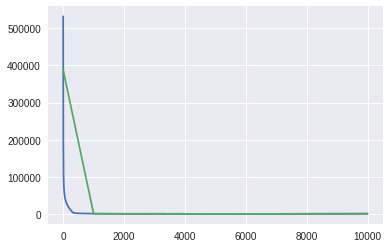

In [161]:
plt.plot(errors_baseline)
plt.plot(range(0, 10001, 1000), errors_test_baseline)

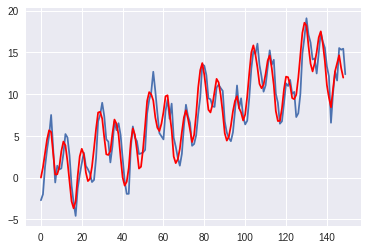

In [162]:
fit = sess.run(res, {x_: ts[None, :150, None]})
plt.plot(ts[None, :150].T)
plt.plot(fit[..., 0].T, 'r')

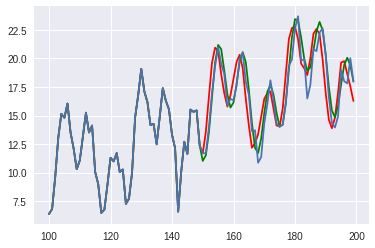

In [163]:
plt.plot(range(100, 200), np.concatenate([ts[None, 100:150, None], pred], 1)[0], 'r')
plt.plot(range(100, 200), np.concatenate([ts[None, 100:150, None], pred_ar[:, :50]], 1)[0], 'g-')
plt.plot(range(100, 200), ts[None, 100:200].T)

# Our Model

In [9]:
class RecognitionNetwork(object):
    
    def __init__(self, data, n_outputs=50, cell_type='GRU', n_hidden=100):
        self._data = data
        self._n_outputs = n_outputs
        self._n_hidden = n_hidden
        self._layer1 = tf.layers.Dense(self._n_outputs)
        self._layer2 = tf.layers.Dense(self._n_outputs, tf.nn.softplus)

        if cell_type == 'GRU':
            self._cell = tf.contrib.rnn.GRUBlockCell(self._n_hidden)
        elif cell_type == 'LSTM':
            self._cell = tf.contrib.rnn.LSTMBlockCell(self._n_hidden)
        elif cell_type == 'RNN':
            self._cell = tf.contrib.rnn.BasicRNNCell(self._n_hidden)
                
    @define_scope       
    def make_posterior_z(self):        
        (out, _) = tf.nn.dynamic_rnn(self._cell, self._data, dtype=tf.float32)
        means = self._layer1(out[:, -1])
        stds = self._layer2(out[:, -1])
        return tfd.MultivariateNormalDiag(means, stds)

class GaussianCellFixedSigma(tf.contrib.rnn.RNNCell):
    """
    RNN cell that outputs mean and standard deviation at every step
    """

    def __init__(self, cell, event_size, batch_size, reuse=None):
        super(GaussianCellFixedSigma, self).__init__(_reuse=reuse)
        self._cell = cell
        self._event_size = event_size
        self._batch_size = batch_size
        self._std = tf.nn.softplus(tf.get_variable(shape=(1, event_size), name='cell_std',
                                                   initializer=tf.constant_initializer(1)))

    @property
    def state_size(self):
        return self._cell.state_size

    @property
    def output_size(self):
        return (self._event_size, self._event_size)

    def call(self, inputs, state):
        _, hidden = self._cell(inputs, state)
        mean = tf.layers.dense(hidden, self._event_size)
        return (mean, tf.tile(self._std, [self._batch_size, 1])), hidden

class SamplingCellWithInputs(tf.contrib.rnn.RNNCell):
    """
    RNN cell that produce a sequence in autoregressive mode by sampling at
    each step
    """

    def __init__(self, cell, output_size, n_samples=1, reuse=None):
        super(SamplingCellWithInputs, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size
        self._n_samples = n_samples

    @property
    def state_size(self):
        return (self._cell.state_size, self._output_size)

    @property
    def output_size(self):
        return (self._output_size, self._output_size)

    def call(self, inputs, state_and_sample):
        (state, sample) = state_and_sample
        sample = tf.concat([sample, inputs], 1)
        (mean, std), state = self._cell(sample, state)
        sample = tfd.Normal(mean, std).sample()
        return (mean, std), (state, sample)
    
class SamplingCell(tf.contrib.rnn.RNNCell):
    """
    RNN cell that produce a sequence in autoregressive mode by sampling at
    each step
    """

    def __init__(self, cell, output_size, n_samples=1, reuse=None):
        super(SamplingCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size
        self._n_samples = n_samples

    @property
    def state_size(self):
        return (self._cell.state_size, self._output_size)

    @property
    def output_size(self):
        return (self._output_size, self._output_size, self._output_size)

    def call(self, _ , state_and_sample):
        (state, sample) = state_and_sample
        (mean, std), state = self._cell(sample, state)
        sample = tfd.Normal(mean, std).sample()
        return (mean, std, sample), (state, sample)
    
class RobustARGenerator(object):
    """
    Model to test
    """
    def __init__(self, data, n_hidden=100, n_samples=200, seq_length=1000, batch_size=1, first_hidden=None):
        self._data = data
        self._n_hidden = n_hidden
        self._batch_size = batch_size
        self._n_samples = n_samples
        self._seq_length = seq_length
        self._z = first_hidden
        
        self._optimiser = tf.train.AdamOptimizer(0.001)
        self._gen_stddev = tf.nn.softplus(tf.get_variable('generative_std', shape=(), 
                                           initializer=tf.constant_initializer(1)))
        self.make_posterior
        raise Exception
        self.make_transitional
        self.compute_elbo

    @define_scope
    def make_posterior(self):
        self._post_gru_cell = tf.contrib.rnn.GRUBlockCell(self._n_hidden)
        batch_size = n_samples_z * self._batch_size * self._n_samples
        self._post_cell = GaussianCellFixedSigma(self._post_gru_cell, 1, batch_size)
        self._post_stddev = tf.squeeze(self._post_cell._std)
        self._post_sampling_cell = SamplingCell(self._post_cell, 1)
        self._post_stddev_y1 = tf.nn.softplus(tf.get_variable('post_std_y0', shape=(), 
                                              initializer=tf.constant_initializer(2)))
        y1_mean = tf.layers.dense(self._z, 1)
        y1_post_dist = tfd.Normal(y1_mean, self._post_stddev_y1)
        y1_samples = y1_post_dist.sample((self._n_samples))
        y1_samples_resh = tf.reshape(y1_samples, [-1,1])        
        z_post_resh = tf.tile(self._z, [self._n_samples, 1])
        fake_data = tf.zeros((n_samples_z * self._batch_size * self._n_samples, self._seq_length-1, 1))
            
        h0 = (z_post_resh, y1_samples_resh)
        (_, _, samples), _ = tf.nn.dynamic_rnn(self._post_sampling_cell, inputs=fake_data, initial_state=h0)
        self._code = tf.concat([y1_samples_resh[..., None], samples], 1)
        print(self._code.shape)
    
    @define_scope
    def make_transitional(self):
        self._cell = tf.contrib.rnn.GRUBlockCell(self._n_hidden)
        self._trans_gaussian_cell = GaussianCellFixedSigma(self._cell, 1, batch_size * self._n_samples)
        self._trans_stddev_y1 = tf.nn.softplus(tf.get_variable('trans_std_y0', shape=(), 
                                               initializer=tf.constant_initializer(0.5)))
        
        y1_trans_mean = tf.layers.dense(self._z, 1)
        _, h1 = self._cell(self._code[:, 0], tf.tile(self._z, [self._n_samples, 1]))
        (means, _), _ = tf.nn.dynamic_rnn(self._trans_gaussian_cell, inputs=self._code[:, 1:], initial_state=h1)
        return y1_trans_mean[None, ...], means
    
    @define_scope
    def compute_elbo(self):
        entropy = self._batch_size * (self._seq_length * tf.log(self._post_stddev) + tf.log(self._post_stddev_y1))
        entropy = entropy + tf.reduce_sum(q_z.entropy()) + tf.reduce_sum(p_z.log_prob(z_post))
        
        (m0, means) = self.make_transitional
        
        y0_code = tf.reshape(self._code[:, 0], [self._n_samples, self._batch_size])
        exponent_y0 = tf.square(tf.reshape(self._code[:, 0], [self._n_samples, self._batch_size, 1]) - m0)
            
        log_y0 = tf.reduce_sum(tf.reduce_mean(exponent_y0/tf.square(self._trans_stddev_y1), 0))
        
        exponent_trans = tf.square(self._code[:, 1:, 0] - means[..., 0])
        exponent_trans = tf.reshape(exponent_trans, [self._n_samples, self._batch_size, self._seq_length-1])
        
        kl = - entropy + tf.reduce_sum(tf.reduce_mean(exponent_trans, 0))/tf.square(self.trans_std) + log_y0
        kl = kl + self._batch_size * (self._seq_length - 1) * tf.log(tf.square(self.trans_std))
        kl = kl + self._batch_size * tf.log(tf.square(self._trans_stddev_y1))
        kl = kl - tf.reduce_sum(p_z.log_prob(z_post))
        
        code = tf.reshape(self._code[..., 0], [self._n_samples, self._batch_size, self._seq_length])
        exp1 = tf.square(code - self._data[None, :self._batch_size, ..., 0])
        exponent_gen = tf.reduce_sum(tf.reduce_mean(exp1, 0))/tf.square(self._gen_stddev)
        
        reconstruction = - exponent_gen - self._seq_length * self._batch_size * tf.log(tf.square(self._gen_stddev))

        return reconstruction - kl, kl, reconstruction, entropy
    
    @define_scope
    def trans_std(self):
        return tf.reduce_mean(self._trans_gaussian_cell._std)
    
    @define_scope
    def gen_std(self):
        return self._gen_stddev
    
    @define_scope
    def post_means(self):
        code = tf.reshape(self._code[..., 0], [self._n_samples, self._batch_size, self._seq_length]) 
        return tf.reduce_mean(code, 0)

# The EM procedure is currently incorrect - amend it
def E_step(loss):
    post_var = [v for v in tf.trainable_variables() if v.name.startswith('make_posterior')]
    return gen_model._optimiser.minimize(loss, var_list=post_var)

def M_step(loss):
    non_post_var = [v for v in tf.trainable_variables() if not v.name.startswith('make_posterior')]
    return gen_model._optimiser.minimize(loss, var_list=non_post_var)

In [7]:
a = np.random.randn(5, 10, 1)
b = np.reshape(a, [-1, 1])
print(np.all(np.equal(np.reshape(b, [5, 10, 1]), a)))
a2 = np.random.randn(5, 10, 1)
c = np.stack([b, np.reshape(a2, [-1, 1])], 0)
d = np.reshape(c, [2,5,10,1])
print(np.all(np.equal(d[0], a)))
print(np.all(np.equal(d[1], a2)))

True
True
True


In [10]:
tf.reset_default_graph()

seq_length = 150 
n_samples_z = 20
n_samples_y = 20
batch_size = 10
n_hidden_p = 15
n_hidden_q = 15

x_ = tf.placeholder(tf.float32, [batch_size, seq_length, 1])

rec_model = RecognitionNetwork(x_, n_hidden_q)
q_z = rec_model.make_posterior_z
p_z = tfd.MultivariateNormalDiag(tf.zeros(n_hidden_q), tf.ones(n_hidden_q))
z_post = q_z.sample((n_samples_z))
print(z_post.shape)
z_post = tf.reshape(z_post, [-1, n_hidden_q])
print(z_post.shape)

gen_model = RobustARGenerator(x_, n_hidden=n_hidden_p, n_samples=n_samples_y, seq_length=seq_length, 
                              batch_size=batch_size, first_hidden=z_post)

loss = - gen_model.compute_elbo[0]
e_step = E_step(loss)
m_step = M_step(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

elbos = []; kls = []; llks = []; test_elbos = []; preds = []; preds_greedy = []
means = []; stds = []; gen_stddevs = []; post_stddevs = []; post_means = []; post_means = []

for i in range(20001):
    batch = y_tilde[:batch_size, :seq_length]
    
    if i % 10 == 0:
        elbo, kl, llk, entropy = sess.run(gen_model.compute_elbo, {x_: batch[..., None]})
        elbos.append(elbo); kls.append(kl); llks.append(llk)
        post_means.append(sess.run(gen_model.post_means, {x_: batch[..., None]})) 
        post_stddevs.append(sess.run(gen_model._post_stddev))
        m = sess.run(gen_model.make_transitional, {x_: batch[..., None]})
        s = sess.run(gen_model.trans_std, {x_: batch[..., None]})
        means.append(m); stds.append(s); gen_stddevs.append(sess.run(gen_model.gen_std, {x_: batch[..., None]}))
        latents = sess.run(gen_model._code, {x_: batch[..., None]})
        post_samples.append(latents)
        print('Iteration:', i, 'ELBO:', elbo, 'KL:', kl, 'Reconstruction:', llk, 'Entropy:', entropy)
    
    sess.run(e_step, {x_: batch[..., None]})
    sess.run(m_step, {x_: batch[..., None]})

(20, 10, 15)
(200, 15)
(4000, 150, 1)


Exception: 

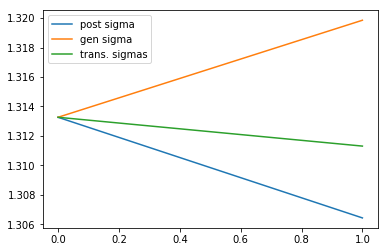

In [528]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
plt.plot(np.squeeze(np.array(post_stddevs)), label='post sigma')
plt.plot(gen_stddevs, label='gen sigma')
plt.plot([np.mean(s) for s in stds], label='trans. sigmas')
plt.legend();

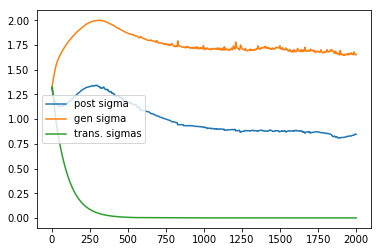

In [492]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
plt.plot(np.squeeze(np.array(post_stddevs)), label='post sigma')
plt.plot(gen_stddevs, label='gen sigma')
plt.plot([np.mean(s) for s in stds], label='trans. sigmas')
plt.legend();

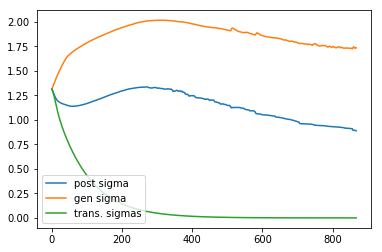

In [489]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
plt.plot(np.squeeze(np.array(post_stddevs)), label='post sigma')
plt.plot(gen_stddevs, label='gen sigma')
plt.plot([np.mean(s) for s in stds], label='trans. sigmas')
plt.legend();

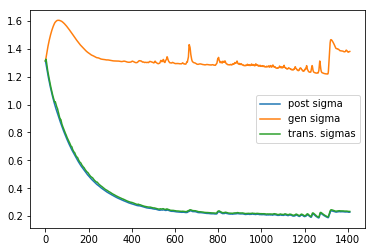

In [335]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
plt.plot(np.squeeze(np.array(post_stddevs)), label='post sigma')
plt.plot(gen_stddevs, label='gen sigma')
plt.plot([np.mean(s) for s in stds], label='trans. sigmas')
plt.legend();

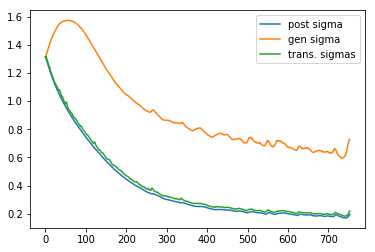

In [330]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
plt.plot(np.squeeze(np.array(post_stddevs)), label='post sigma')
plt.plot(gen_stddevs, label='gen sigma')
plt.plot([np.mean(s) for s in stds], label='trans. sigmas')
plt.legend();

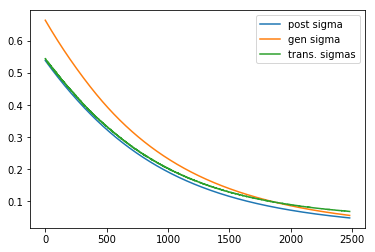

In [43]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
plt.plot(np.squeeze(np.array(post_stddevs))[1000:], label='post sigma')
plt.plot(gen_stddevs[1000:], label='gen sigma')
plt.plot([np.mean(s) for s in stds][1000:], label='trans. sigmas')
plt.legend();

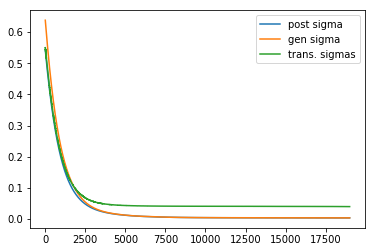

In [9]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
plt.plot(np.squeeze(np.array(post_stddevs))[1000:], label='post sigma')
plt.plot(gen_stddevs[1000:], label='gen sigma')
plt.plot([np.mean(s) for s in stds][1000:], label='trans. sigmas')
plt.legend();

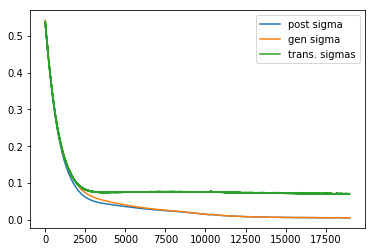

In [296]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (1 sample)
plt.plot(np.squeeze(np.array(post_stddevs))[1000:], label='post sigma')
plt.plot(gen_stddevs[1000:], label='gen sigma')
plt.plot([np.mean(s) for s in stds][1000:], label='trans. sigmas')
plt.legend();

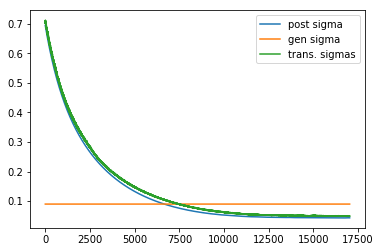

In [292]:
# p is RNN + linear proj., sigma_c is known, q is an RNN on the observed values + linear proj.
plt.plot(np.squeeze(np.array(post_stddevs))[1000:], label='post sigma')
plt.plot(gen_stddevs[1000:], label='gen sigma')
plt.plot([np.mean(s) for s in stds][1000:], label='trans. sigmas')
plt.legend();

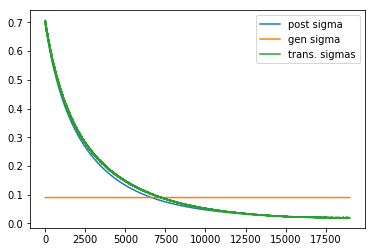

In [277]:
# p is RNN + linear proj., sigma_c is known, q is fully factorised
plt.plot(np.squeeze(np.array(post_stddevs))[1000:], label='post sigma')
plt.plot(gen_stddevs[1000:], label='gen sigma')
plt.plot([np.mean(s) for s in stds][1000:], label='trans. sigmas')
plt.legend();

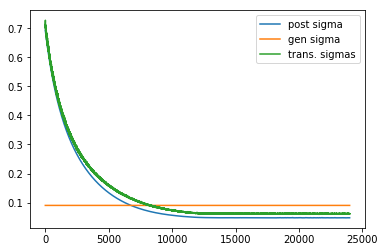

In [267]:
# p is linear, sigma_c is known, q is fully factorised
plt.plot(np.squeeze(np.array(post_stddevs))[1000:], label='post sigma')
plt.plot(gen_stddevs[1000:], label='gen sigma')
plt.plot([np.mean(s) for s in stds][1000:], label='trans. sigmas')
plt.legend();

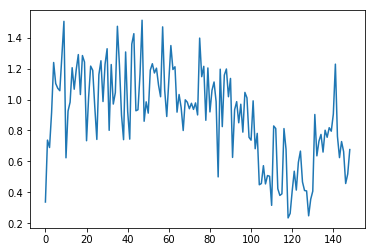

In [481]:
for i in range(1):
    plt.plot(post_means[-1][i][1:])

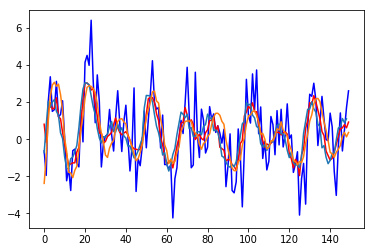

In [498]:
plt.plot(y_tilde[0, :150], 'b')
plt.plot(post_means[-1][0], 'r')
plt.plot(np.mean(np.mean(np.reshape(means[-1][1], [20, 1, 149]), 0),0))
plt.plot(y[1:151], label='true sinusoid')

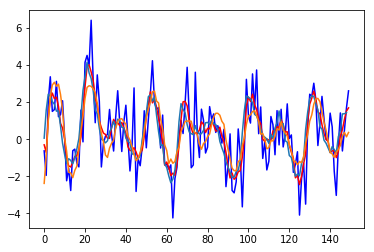

In [496]:
plt.plot(y_tilde[0, :150], 'b')
plt.plot(post_means[-1][0], 'r')
plt.plot(np.mean(np.mean(np.reshape(means[-1][1], [20, 1, 149]), 0),0))
plt.plot(y[1:151], label='true sinusoid')

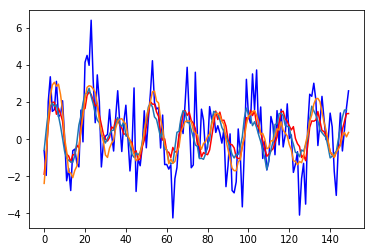

In [493]:
plt.plot(y_tilde[0, :150], 'b')
plt.plot(post_means[-1][0], 'r')
plt.plot(np.mean(np.mean(np.reshape(means[-1][1], [20, 1, 149]), 0),0))
plt.plot(y[1:151], label='true sinusoid')

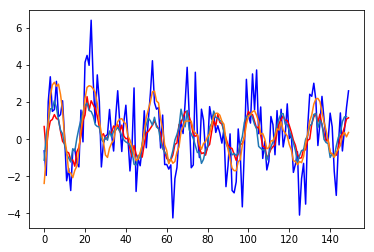

In [490]:
plt.plot(y_tilde[0, :150], 'b')
plt.plot(post_means[-1][0], 'r')
plt.plot(np.mean(np.mean(np.reshape(means[-1][1], [20, 1, 149]), 0),0))
plt.plot(y[1:151], label='true sinusoid')

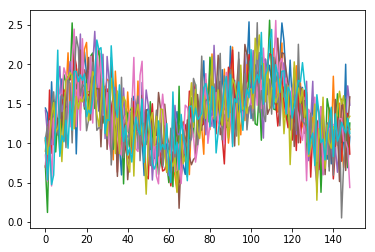

In [288]:
for i in range(10):
    plt.plot(np.mean(np.reshape(means[-1][1], [20, 10, 149])[i], 0))

In [ ]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
plt.plot(y_tilde[1, :seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
# plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.reshape(latents, [-1, seq_length]), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[1:seq_length], label='true sinusoid')
plt.legend();

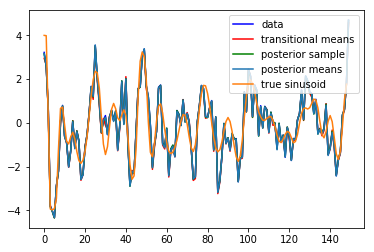

In [351]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
plt.plot(y_tilde[0, :seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
# plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.reshape(latents, [-1, seq_length]), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[1:seq_length], label='true sinusoid')
plt.legend();

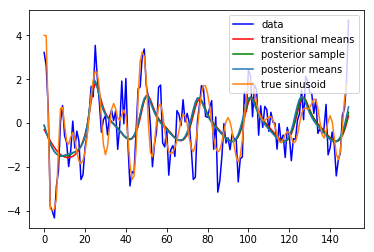

In [341]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
plt.plot(y_tilde[0, :seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
# plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.reshape(latents, [-1, seq_length]), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[1:seq_length], label='true sinusoid')
plt.legend();

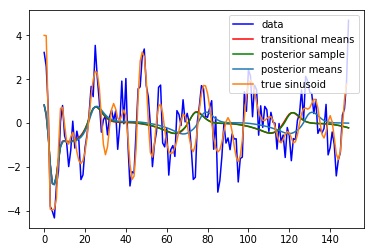

In [339]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
plt.plot(y_tilde[0, :seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
# plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.reshape(latents, [-1, seq_length]), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[1:seq_length], label='true sinusoid')
plt.legend();

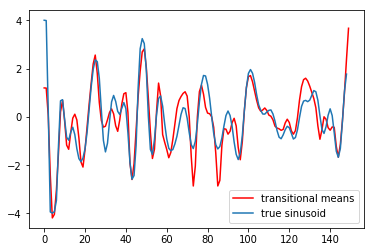

In [332]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
# plt.plot(y_tilde[0, :seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
# plt.plot(stds[-1], 'k', label='transitional stddev')
# plt.plot(np.mean(np.reshape(latents, [-1, seq_length]), 0), 'g', label='posterior sample')
# plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[1:seq_length], label='true sinusoid')
plt.legend();

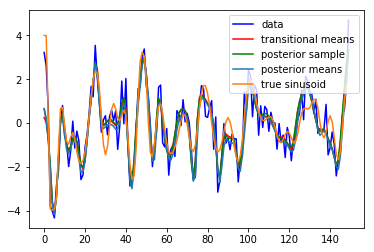

In [327]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
plt.plot(y_tilde[0, :seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
# plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.reshape(latents, [-1, seq_length]), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[1:seq_length], label='true sinusoid')
plt.legend();

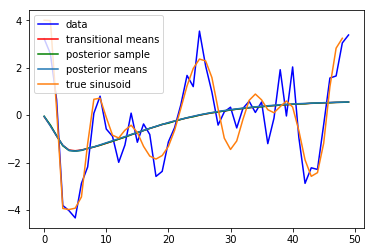

In [314]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
plt.plot(y_tilde[0, :seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
# plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.reshape(latents, [-1, seq_length]), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[1:seq_length], label='true sinusoid')
plt.legend();

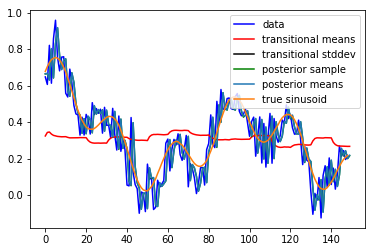

In [59]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
plt.plot(y_tilde[0, 1:150], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.reshape(latents, [-1, 150]), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[1:150], label='true sinusoid')
plt.legend();

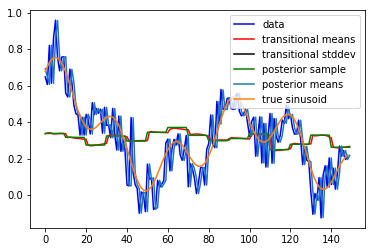

In [33]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
plt.plot(y_tilde[0, 1:seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(latents, 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[1:seq_length], label='true sinusoid')
plt.legend();

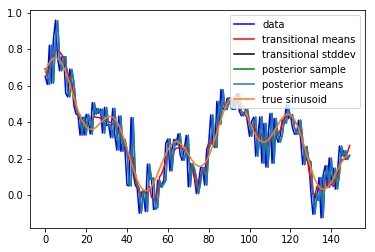

In [297]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (1 sample)
plt.plot(y_tilde[0, 1:seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.stack(latents, 0), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[1:seq_length], label='true sinusoid')
plt.legend();

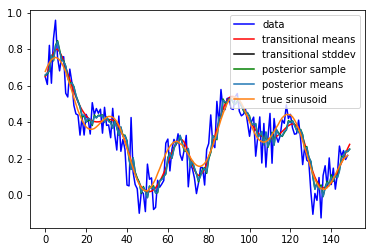

In [293]:
# p is RNN + linear proj., sigma_c is known, q is an RNN on the observed values + linear proj.
plt.plot(y_tilde[0, 1:seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.stack(latents, 0), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[1:seq_length], label='true sinusoid')
plt.legend();

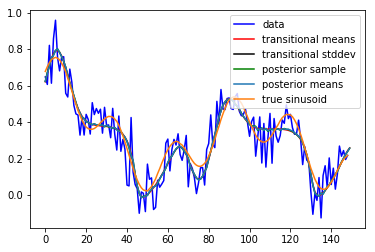

In [279]:
# p is RNN + linear proj., sigma_c is known, q is fully factorised
plt.plot(y_tilde[0, 1:seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.stack(latents, 0), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[1:seq_length], label='true sinusoid')
plt.legend();

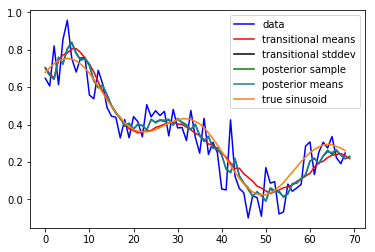

In [272]:
# p is linear, sigma_c is known, q is fully factorised
plt.plot(y_tilde[0, 1:seq_length], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.stack(latents, 0), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[1:70], label='true sinusoid')
plt.legend();

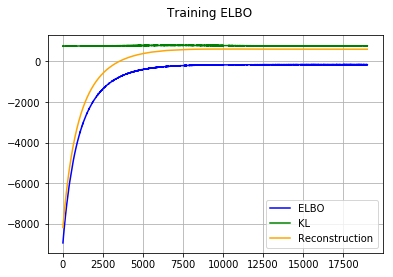

In [282]:
# p is RNN + linear proj., sigma_c is known, q is fully factorised
plt.plot(elbos[1000:], 'b', label='ELBO')
plt.plot(kls[1000:], 'g', label='KL')
plt.plot(llks[1000:], 'orange', label='Reconstruction')
plt.suptitle('Training ELBO')
plt.grid("on")
plt.legend()
plt.show()